In this notebook, we perform clustering for cell sequencing data via a "classic approach" using umap and via an novel information based approach which uses the a distance matrix $M$ with the pairwise distances between distributions of cells in the space of genes.

In [43]:
import pandas as pd
import numpy as np
import math
from scipy.stats import iqr
from numpy import histogram2d
from numpy import histogram
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
from persim import plot_diagrams 
from ripser import ripser, lower_star_img
from sklearn.cluster import KMeans
from scipy.stats.contingency import crosstab
import scanpy as sc

# Define mutual information function
def W1_distance(U,V):
    return np.trapz(np.abs(U-V))

Importing the experimental data and its metadata

In [44]:
import pandas as pd
## tell pandas to make a new DataFrame with the contents of `brain_counts.csv`. This might take a minute.
count_dataframe = pd.read_csv("ClusterCells_GE_UMAP_1D/CellSorted_SRR12615659_GE_matrix_filtered.csv", # where to find the data
                              index_col=0).T # use the first column to label the rows (the 'index')
metadata_dataframe = pd.read_csv("ClusterCells_GE_UMAP_1D/SRR12615659_cluster_sample.csv", # where to find the data
                              index_col=1)

We use Scanpy to create an object containing a matrix X with cells as rows and genes as columns

In [45]:
import scanpy as sc
adata = sc.AnnData(X = count_dataframe, obs = metadata_dataframe)
print(adata)

AnnData object with n_obs × n_vars = 826 × 4674
    obs: 'Cell_Index', 'Cell_Type', 'Cell_Marker', 'Cell_Name'


In [46]:
adata.write('mymethod/cells_raw.h5ad')

# Normalization & PCA 

Before clustering we make some plots with the principal component analysis of the matrix X after normalising it and after log-transforming it. The plots permit us to see if there is a highly expresses gene which could add noise to the clustering. Also the plots permit us to see that after log-transformatio the gene's PCAs are smoothly separated.

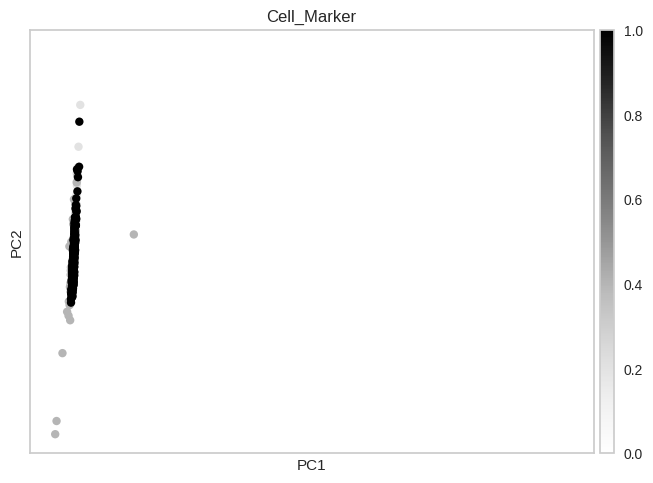

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


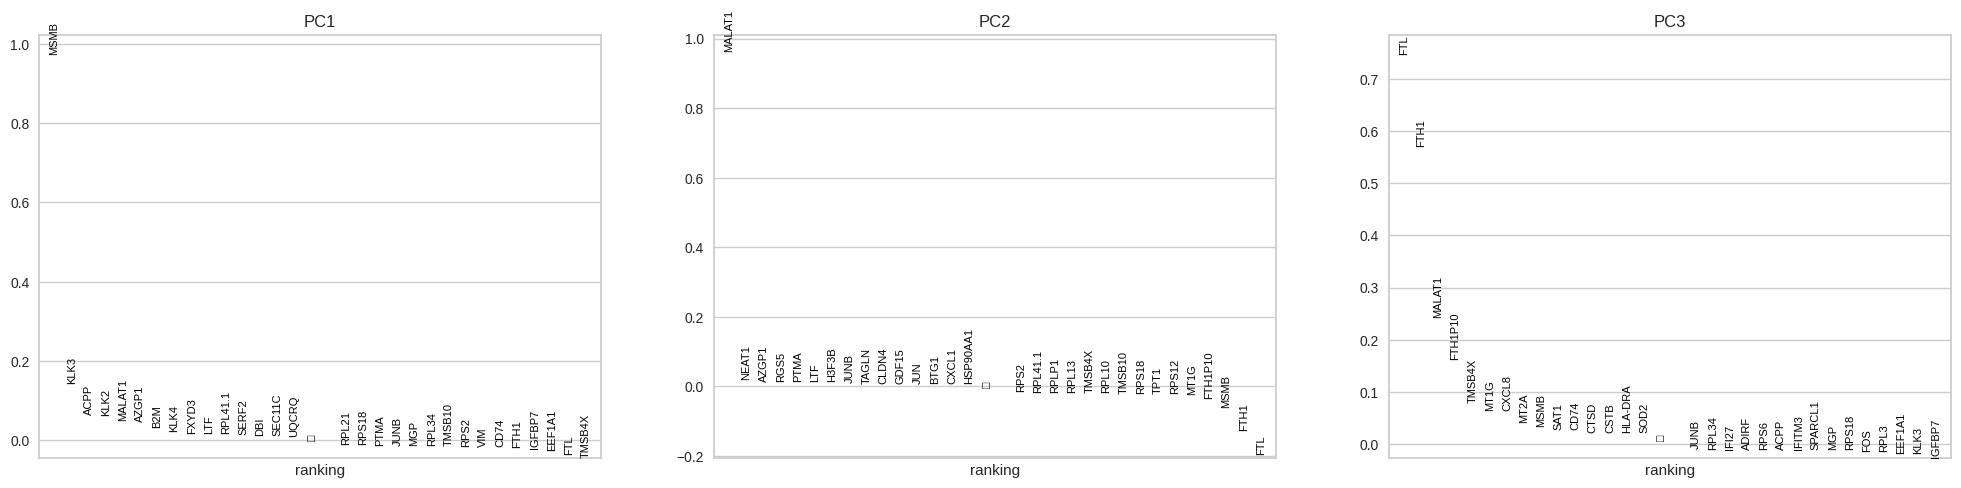

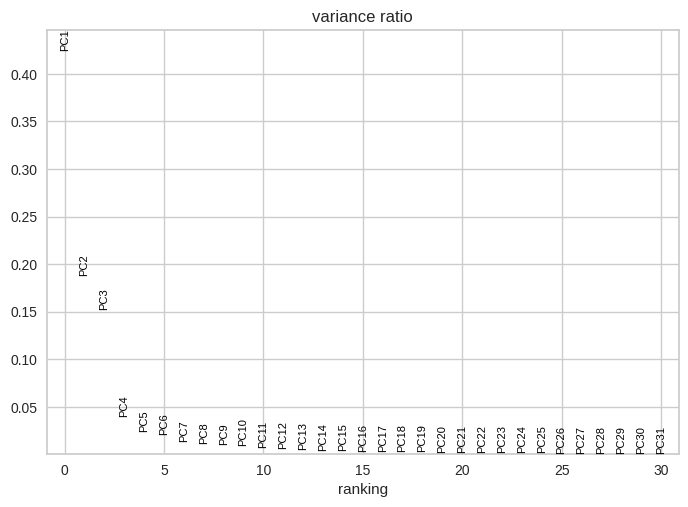

In [57]:
adata_cpm = adata.copy() # make a copy so we can compare results
adata_cpm.raw = adata_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_total(adata_cpm, target_sum=1e6, exclude_highly_expressed=True) # normalize
sc.pp.pca(adata_cpm) # run pca
sc.pl.pca_overview(adata_cpm, color='Cell_Marker') # plot pca

Log transform the data $\log(X+1)$

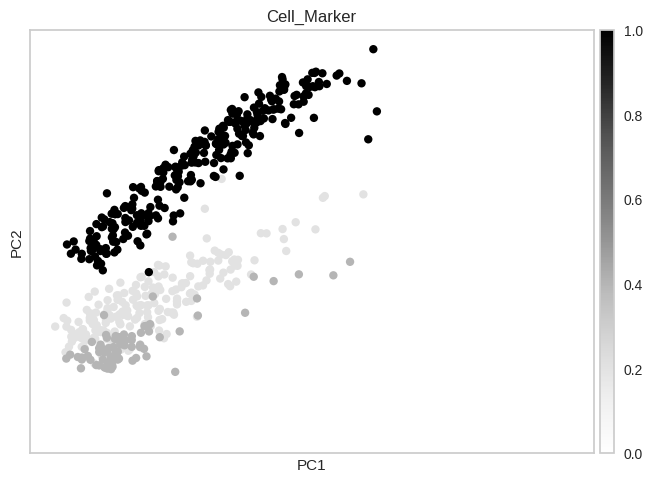

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


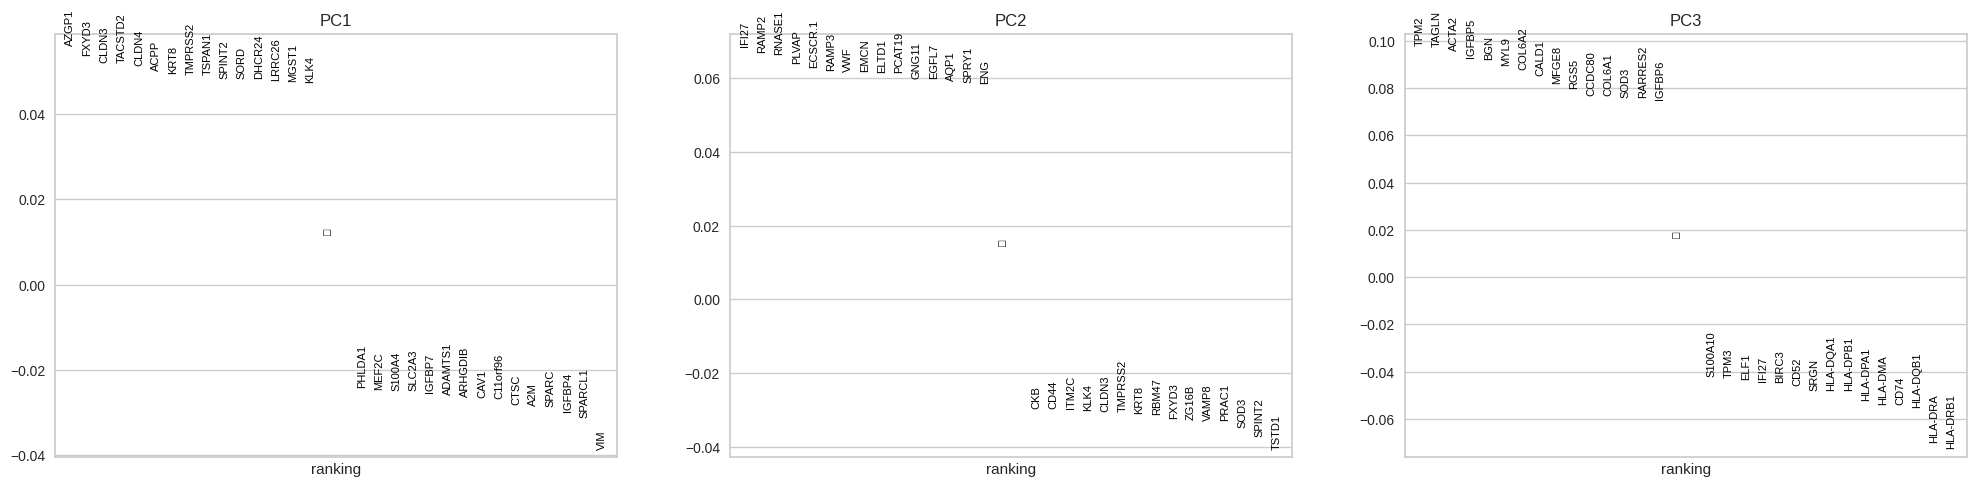

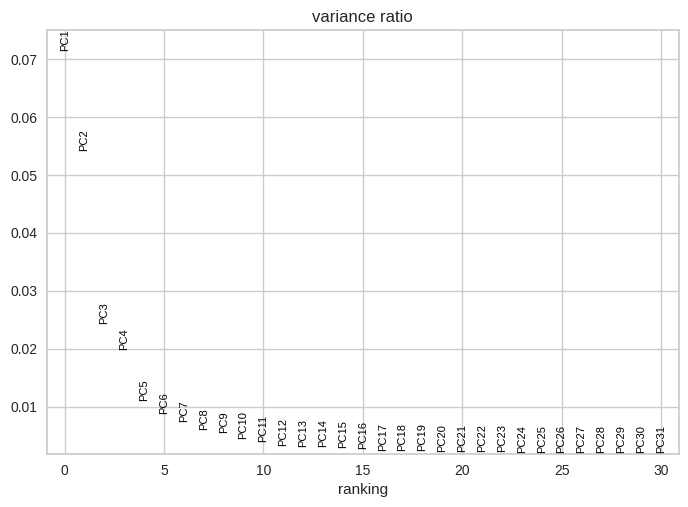

In [58]:
sc.pp.log1p(adata_cpm)
#sc.pp.scale(adata_cpm)
sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='Cell_Marker')

In [59]:
adata_cpm.write('mymethod/cells_normalized.h5ad')

# Dimensionality reduction  (non-information based method)

In [61]:
adata = sc.read('mymethod/cells_normalized.h5ad')

Application of UMAP algorithm

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


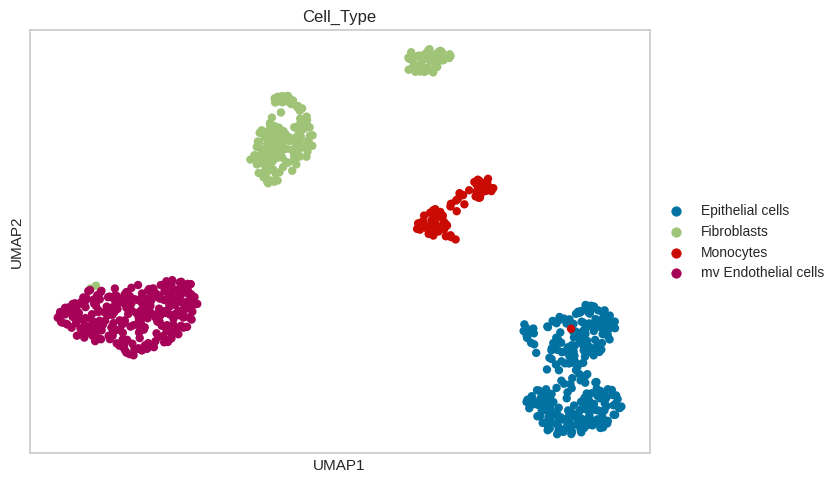

In [62]:
#UMAP
sc.pp.neighbors(adata) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)
sc.pl.umap(adata, color='Cell_Type')

In [63]:
adata.write('mymethod/cells_embeddings.h5ad')

# Clustering (non- information based method)

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
%matplotlib inline

adata = sc.read('mymethod/cells_embeddings.h5ad')

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


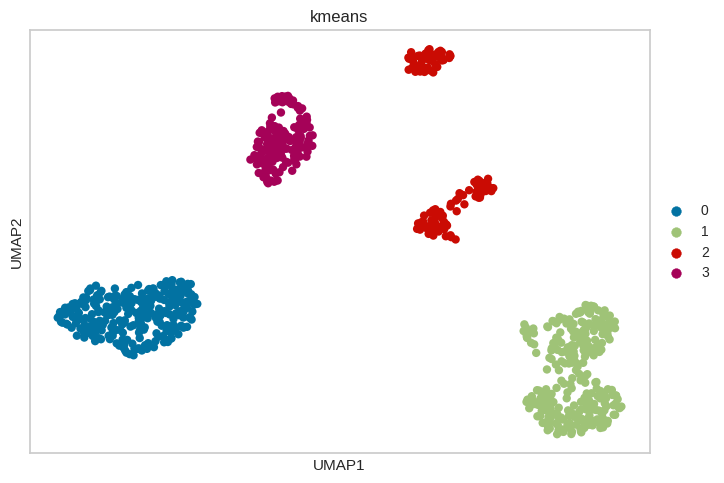

In [65]:
umap_coordinates = adata.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

Evaluating clustering

In [30]:
rand_index = adjusted_rand_score(labels_true = adata.obs['Cell_Type'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.91


In [31]:
adata.write('mymethod/cells_clusters.h5ad')

## Dimensionality reduction (Information based method)

We now perform an information based method for clustering cells. The method uses a pairwise distance matrix via the $W_1$ wasserstein metric. Note that the $W_1$ distance between two cumulative density functions $u,v$ of and equals to:
$$W_1(u,v)=\int_{-\infty}^{\infty}|U-V|$$
In this approach, we treat each row as a cumulative density function whose space is an ordered-categorical space of the genes that have been expressed. See the figure below:

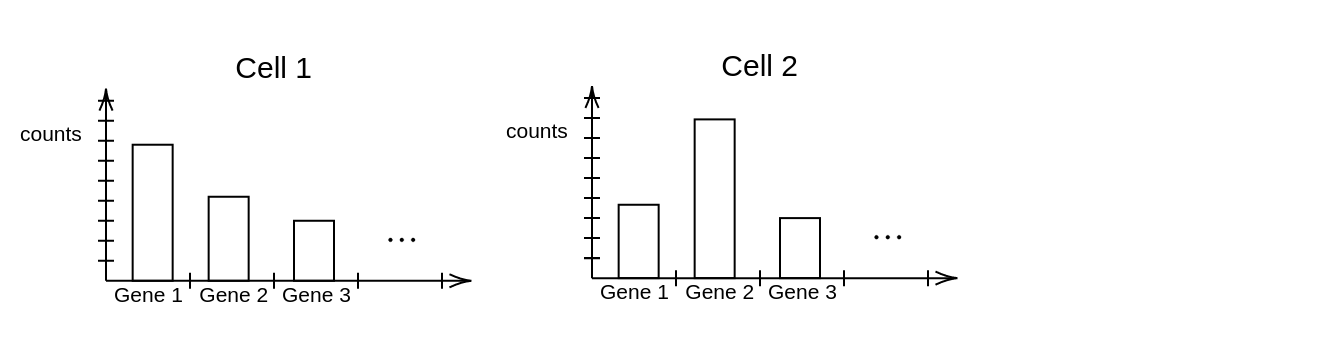

$M_w$ is a symetric matrix of the form 

In [66]:
adata = sc.read('mymethod/cells_normalized.h5ad')
#Build MI matrix
batch_size_features= adata.X.shape[0]

Mw_matrix = np.zeros((batch_size_features,batch_size_features)) #w distance matrix

for col_i in range(0,batch_size_features):
    for col_j in range(col_i,batch_size_features):
        Mw_matrix[col_i,col_j] = W1_distance(adata.X[col_i,:]
                                                      ,adata.X[col_j,:])

Mw_matrix= Mw_matrix+Mw_matrix.T-np.diag(np.diag(Mw_matrix))

In [67]:
np.savetxt("mymethod/Mw1_matrix.csv", Mw_matrix, delimiter=",")

#Save distances matrix

In [68]:
Mw_matrix=np.loadtxt("mymethod/Mw1_matrix.csv", delimiter=",")
adata = sc.read('mymethod/cells_normalized.h5ad')

Text(0.5, 1.0, 'Wasserstein distances matrix')

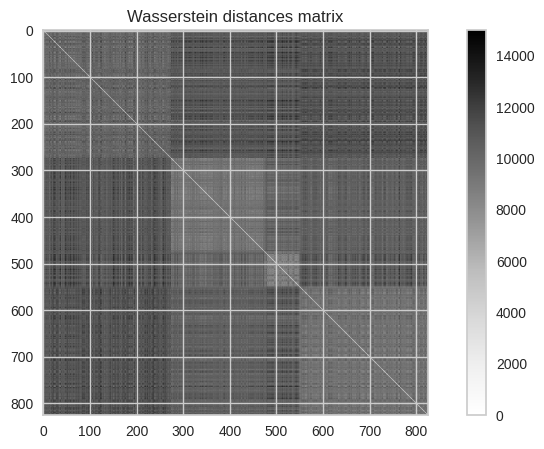

In [70]:
dgm = lower_star_img(Mw_matrix)
plt.figure(figsize=(10, 5))
plt.imshow(Mw_matrix)
plt.colorbar()
plt.title("Wasserstein distances matrix")

We now perform the clustering via multidimensional scaling (MDS) and the Kmeans algorithm. First, MDS translates the information about the pairwise 'distances' among the elements on the distance matrix which can permit us to perform the Kmeans clustering. To find the best dimension where the matrix 𝑀 can be translated to, we perform the stress index for dimensions 1 to 25 and use a simple elbow rule to detect which dimension is the best. The result gives dimension 5 as closely the best option.

Text(0.5, 0, 'Dimension')

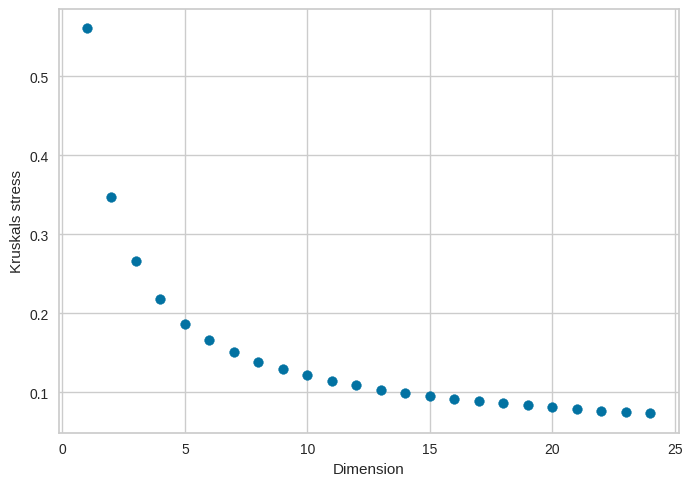

In [71]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
s,si=[],[]
stress1,i=1,1
while i<25:
    mds = MDS(n_components=i,dissimilarity='precomputed', random_state=0, normalized_stress='auto')
    # Get the embeddings
    X_transform = mds.fit_transform(Mw_matrix)
    ## Kruskal's stress (or stress formula 1)
    DE = euclidean_distances(X_transform)
    stress = 0.5 * np.sum((DE - Mw_matrix)**2)
    stress1=np.sqrt(stress / (0.5 * np.sum(Mw_matrix**2)))
    s.append(stress1)
    si.append(i)
    i=i+1
plt.scatter(si,s)
plt.ylabel('Kruskals stress')
plt.xlabel('Dimension')

In [72]:
mds = MDS(n_components=5,dissimilarity='precomputed',
          random_state=0, normalized_stress='auto')
# Get the embeddings
X_transform = mds.fit_transform(Mw_matrix)

Similarly to the MDS procedure, for Kmeans algorithm we perform the elbow rule to detect the best number of clusters that we should use in our algorithm. The result is 5.

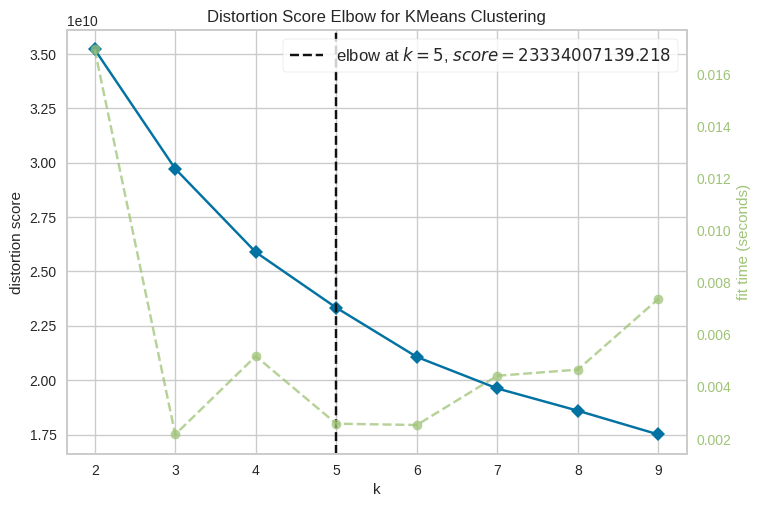

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [73]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42,n_init='auto')
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(X_transform)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Here, we plot only 2 dimensions of the space obtained via MDS for visualisation purposes.

<Axes: >

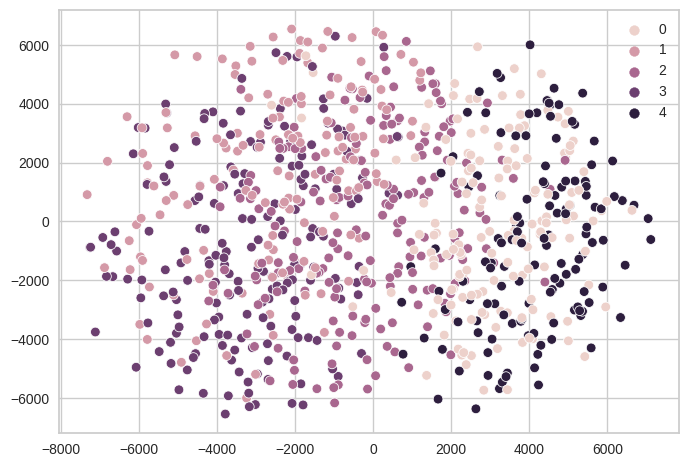

In [74]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

kmeans_model = KMeans(n_clusters = 5,n_init='auto')
kmeans_model.fit(X_transform)
sns.scatterplot(x=X_transform[:,0],y=X_transform[:,1],hue=kmeans_model.labels_)


Perform a comparison between the pre-known labels and the labels produced via the kmeans algorithm.

In [75]:
adata.obs['kmeans'] = kmeans_model.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

In [78]:
#evaluating clustering
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(labels_true = adata.obs['Cell_Type'], labels_pred = adata.obs['kmeans'])
print('The score index is', round(rand_index, 2))

The score index is 0.62


In [79]:
import hdbscan
clusterer = hdbscan.HDBSCAN(algorithm='best',metric='precomputed',min_cluster_size=5)
clusterer.fit(Mw_matrix)
adata.obs['hdbscan'] = clusterer.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['hdbscan'] = adata.obs['hdbscan'].astype(str)
#evaluating clustering
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(labels_true = adata.obs['Cell_Type'], labels_pred = adata.obs['hdbscan'])
print('The score index is', round(rand_index, 2))

The score index is 0.15
